# Temporal auto-correlation

Assessment of model temporal auto-correlation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
from xskillscore import pearson_r, pearson_r_p_value

import utils

Matplotlib is building the font cache; this may take a moment.


In [23]:
# Variable specific settings
variable = 'pr'
name = 'precipitation'
tscale = 'annual'

In [24]:
# Metric calculation



def resample(da, var, timescale):
    """Resample to annual or monthly anomaly timeseries"""
    
    assert timescale in ['monthly', 'annual']
    
    if timescale == 'monthly':
        if var == 'pr':
            monthly_da = da.resample(time='M').sum(dim='time')
        else:
            monthly_da = da.resample(time='M').mean(dim='time')
        monthly_clim = monthly_da.groupby("time.month").mean(dim="time")
        monthly_anom = monthly_da.groupby("time.month") - monthly_clim
        data = monthly_anom
    else:
        if var == 'pr':
            annual_da = da.resample(time='A-DEC').sum(dim='time')
        else:
            annual_da = da.resample(time='A-DEC').mean(dim='time')
        data = annual_da
    data = data.chunk(dict(time=-1))
    
    return data


def autocorrelation(data, lag, return_p=False):
    """Calculate autocorrelation for given lag"""
    
    N = data['time'].size
    normal = data.isel({'time': slice(0, N - lag)})
    shifted = data.isel({'time': slice(0 + lag, N)})
    # Align dimensions for xarray operation.
    shifted['time'] = normal['time']
    corrcoef = pearson_r(normal, shifted, 'time')
    if return_p:
        pval = pearson_r_p_value(normal, shifted, 'time')
        return corrcoef, pval
    else:
        return corrcoef


cities = {
    'Port Hedland': {'lat': -20.3, 'lon': 118.6},
    'Alice Springs': {'lat': -23.7, 'lon': 133.9},
    'Darwin': {'lat': -12.5, 'lon': 131},
    'Cairns': {'lat': -16.9, 'lon': 145},
    'Brisbane': {'lat': -27.5, 'lon': 153.0},
    'Sydney': {'lat': -33.9, 'lon': 151.2},
    'Thredbo': {'lat': -36.5, 'lon': 148.3},
    'Melbourne': {'lat': -37.8, 'lon': 145.0},
    'Hobart': {'lat': -42.9, 'lon': 147.3},
    'Adelaide': {'lat': -34.9, 'lon': 138.6},
    'Perth': {'lat': -32.0, 'lon': 115.9},    
}

    
def get_city_data_dict(da):
    """Build a dictionary with data for each city"""
    
    city_data_dict = {}
    for city in cities:
        city_data_dict[city] = da.sel(cities[city], method='nearest')
        
    return city_data_dict

In [25]:
# Data collection and processing

def get_assessment_time_bounds(gcm, task):
    """Get assessment time bounds for given GCM/task combination"""

    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    return start_date, end_date


def get_training_time_bounds(gcm):
    """Get xvalidation training time bounds for given GCM/task combination"""

    if gcm == 'ECMWF-ERA5':
        start_date = '1980-01-01'
        end_date = '1999-12-31'
    else:
        start_date = '1960-01-01' 
        end_date = '1989-12-31'
    
    return start_date, end_date


def get_obs_data(var, tscale, start_date, end_date):
    """Get obs data"""
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    da_resampled = resample(da_obs, var, timescale)
    lag1_autocorr = autocorrelation(da_resampled, lead=1, return_p=False)
    city_data_dict = get_city_data_dict(da_resampled)
    
    return lag1_autocorr, city_data_dict


def get_gcm_data(var, tscale, gcm, start_date, end_date):
    """Get reference/raw GCM data."""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']

    da_gcm = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )

    return lag1_autocorr(da_gcm, var, tscale)
    

def get_rcm_data(var, tscale, gcm, rcm, start_date, end_date):
    """Get reference/raw RCM data"""
    
    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    
    da_rcm = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    
    return lag1_autocorr(da_rcm, var, tscale)


def get_bias_corrected_rcm_data(var, tscale, gcm, rcm, task, start_date, end_date):
    """Get bias corrected RCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    
    da_dict = {}
    
    da_ecdfm = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_dict['ecdfm'] = lag1_autocorr(da_ecdfm, var, tscale)
    
    da_qme = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_dict['qme'] = lag1_autocorr(da_qme, var, tscale)
    
    if task == 'xvalidation':
        da_qdm = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
        )
        da_dict['qdm'] = lag1_autocorr(da_qdm, var, tscale)
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict


def get_bias_corrected_gcm_data(var, tscale, gcm, task, start_date, end_date):
    """Get bias corrected GCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert task in ['historical', 'xvalidation']
    
    da_dict = {}
    
    da_ecdfm = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_dict['ecdfm'] = lag1_autocorr(da_ecdfm, var, tscale)
        
    if task == 'xvalidation':
        da_qdm = utils.get_npcp_data(
            var,
            gcm,
            'GCM',
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
        )
        da_dict['qdm'] = lag1_autocorr(da_qdm, var, tscale)
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict

In [26]:
# Plotting

def plot_bias(ax, corr_obs, corr_model, model_name, ob_fractions=None):
    """Plot the bias for a particular model"""
    
    bias = corr_model - corr_obs
    bias = utils.clip_data(bias, utils.get_aus_shape())
    if ob_fractions is not None:
        bias = utils.mask_by_pr_ob_fraction(bias, ob_fractions, threshold=0.9)    
    mae = np.nanmean(np.abs(bias)) 

    bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        levels=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
        extend='both',
        cbar_kwargs={'label': 'correlation'},
    )
    ax.text(0.02, 0.02, f'MAE: {mae:.2f}', transform=ax.transAxes, fontsize='large')
    ax.set_title(model_name)
    ax.coastlines()


def plot_comparison(
    da_obs,
    da_gcm,
    da_rcm,
    gcm_bc_dict,
    rcm_bc_dict,
    da_training_obs,
    gcm,
    rcm,
    task,
    outfile=None,
):
    """Plot the complete comparison"""

    ncols = 5 if task == 'xvalidation' else 3
    plot_nums = np.arange(1, (ncols * 2) + 1)
    ob_fractions = utils.get_pr_weights(gcm, task)
    
    fig = plt.figure(figsize=[7 * ncols, 10])
    
    # GCM bias correction
    plot_index = 0
    ax_gcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_gcm1, da_obs, da_gcm, gcm, ob_fractions=ob_fractions,
    )
    plot_index = plot_index + 1
    ax_gcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_gcm2, da_obs, gcm_bc_dict['ecdfm'], f'{gcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_gcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_gcm4, da_obs, gcm_bc_dict['qdm'], f'{gcm} (qdm)', ob_fractions=ob_fractions,
        )
        plot_index = plot_index + 1

    # RCM bias correction
    plot_index = plot_index + 1
    ax_rcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm1, da_obs, da_rcm, f'{rcm} (raw)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm2, da_obs, rcm_bc_dict['ecdfm'], f'{rcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm3 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm3, da_obs, rcm_bc_dict['qme'], f'{rcm} (qme)', ob_fractions=ob_fractions,
    )
    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_rcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_rcm4, da_obs, rcm_bc_dict['qdm'], f'{rcm} (qdm)', ob_fractions=ob_fractions,
        )
        
        plot_index = plot_index + 1
        ax_rcm5 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_rcm5, da_obs, da_training_obs, f'AGCD (training data)', ob_fractions=ob_fractions,
        )
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    
    plt.suptitle(f'Bias (model minus obs) in lag 1 autocorrelation for {start_year}-2019 {tscale} {name}', fontsize='x-large')
    if outfile:
        print(outfile)
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
def plot_corr(ax, corr, model_name, ob_fractions=None):
    """Plot the autocorrelation for a particular model"""
    
    corr = utils.clip_data(corr, utils.get_aus_shape())
    if ob_fractions is not None:
        corr = utils.mask_by_pr_ob_fraction(corr, ob_fractions, threshold=0.9)    

    corr.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        levels=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
        extend='both',
        cbar_kwargs={'label': 'correlation'},
    )
    ax.set_title(model_name)
    ax.coastlines()


def plot_values(
    da_obs,
    da_gcm,
    da_rcm,
    gcm_bc_dict,
    rcm_bc_dict,
    da_training_obs,
    gcm,
    rcm,
    task,
    outfile=None,
):
    """Plot the autocorrelation for each model/method"""

    ncols = 5 if task == 'xvalidation' else 4
    plot_nums = np.arange(1, (ncols * 2) + 1)
    ob_fractions = utils.get_pr_weights(gcm, task)
    
    fig = plt.figure(figsize=[7 * ncols, 10])
    
    # GCM bias correction
    plot_index = 0
    ax_gcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(
        ax_gcm1, da_gcm, gcm, ob_fractions=ob_fractions,
    )
    plot_index = plot_index + 1
    ax_gcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(
        ax_gcm2, gcm_bc_dict['ecdfm'], f'{gcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_gcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_corr(
            ax_gcm4, gcm_bc_dict['qdm'], f'{gcm} (qdm)', ob_fractions=ob_fractions,
        )

    plot_index = plot_index + 1
    ax_obs = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(ax_obs, da_obs, 'AGCD', ob_fractions=ob_fractions)
        
    # RCM bias correction
    plot_index = plot_index + 1
    ax_rcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(
        ax_rcm1, da_rcm, f'{rcm} (raw)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(
        ax_rcm2, rcm_bc_dict['ecdfm'], f'{rcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm3 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_corr(
        ax_rcm3, rcm_bc_dict['qme'], f'{rcm} (qme)', ob_fractions=ob_fractions,
    )
    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_rcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_corr(
            ax_rcm4, rcm_bc_dict['qdm'], f'{rcm} (qdm)', ob_fractions=ob_fractions,
        )
        
        plot_index = plot_index + 1
        ax_rcm5 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_corr(
            ax_rcm5, da_training_obs, f'AGCD (training data)', ob_fractions=ob_fractions,
        )
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    
    plt.suptitle(f'lag 1 autocorrelation for {start_year}-2019 {tscale} {name}', fontsize='x-large')
    if outfile:
        print(outfile)
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

In [30]:
def plot_rcm(
    var,
    tscale,
    da_obs,
    da_gcm,
    gcm_bc_dict,
    gcm,
    rcm,
    task,
    start_date,
    end_date,
    da_training_obs=None,
    value_plot=False,
    bias_outfile=False,
    value_outfile=False,
):
    """Generate plots for one RCM/GCM combination"""
    
    da_rcm = get_rcm_data(var, tscale, gcm, rcm, start_date, end_date)
    rcm_bc_dict = get_bias_corrected_rcm_data(var, tscale, gcm, rcm, task, start_date, end_date)
    if bias_outfile:
        bias_outfile_name = f'lag1autocorr-bias_task-{task}_{gcm}_{rcm}.png'
    else:
        bias_outfile_name = None
    if value_outfile:
        value_outfile_name = f'lag1autocorr-values_task-{task}_{gcm}_{rcm}.png'
    else:
        value_outfile_name = None
    if value_plot:
        plot_values(
            da_obs,
            da_gcm,
            da_rcm,
            gcm_bc_dict,
            rcm_bc_dict,
            da_training_obs,
            gcm,
            rcm,
            task,
            outfile=value_outfile_name,
        )
    plot_comparison(
        da_obs,
        da_gcm,
        da_rcm,
        gcm_bc_dict,
        rcm_bc_dict,
        da_training_obs,
        gcm,
        rcm,
        task,
        outfile=bias_outfile_name,
    )

## task-historical

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

#### ERA5

In [9]:
#gcm = 'ECMWF-ERA5'
#task = 'historical'
#start_date, end_date = get_assessment_time_bounds(gcm, task)
#da_obs = get_obs_data(variable, tscale, start_date, end_date)
#da_gcm = get_gcm_data(variable, tscale, gcm, start_date, end_date)
#gcm_bc_dict = get_bias_corrected_gcm_data(variable, tscale, gcm, task, start_date, end_date)

In [10]:
#rcm = 'BOM-BARPA-R'
#plot_rcm(variable, tscale, da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date)

In [11]:
#rcm = 'CSIRO-CCAM-2203'
#plot_rcm(variable, tscale, da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date)

In [12]:
#rcm = 'UQ-DES-CCAM-2105'
#plot_rcm(variable, tscale, da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date)

#### ACCESS-ESM1-5

In [19]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'historical'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, tscale, start_date, end_date)
da_gcm = get_gcm_data(variable, tscale, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, tscale, gcm, task, start_date, end_date)

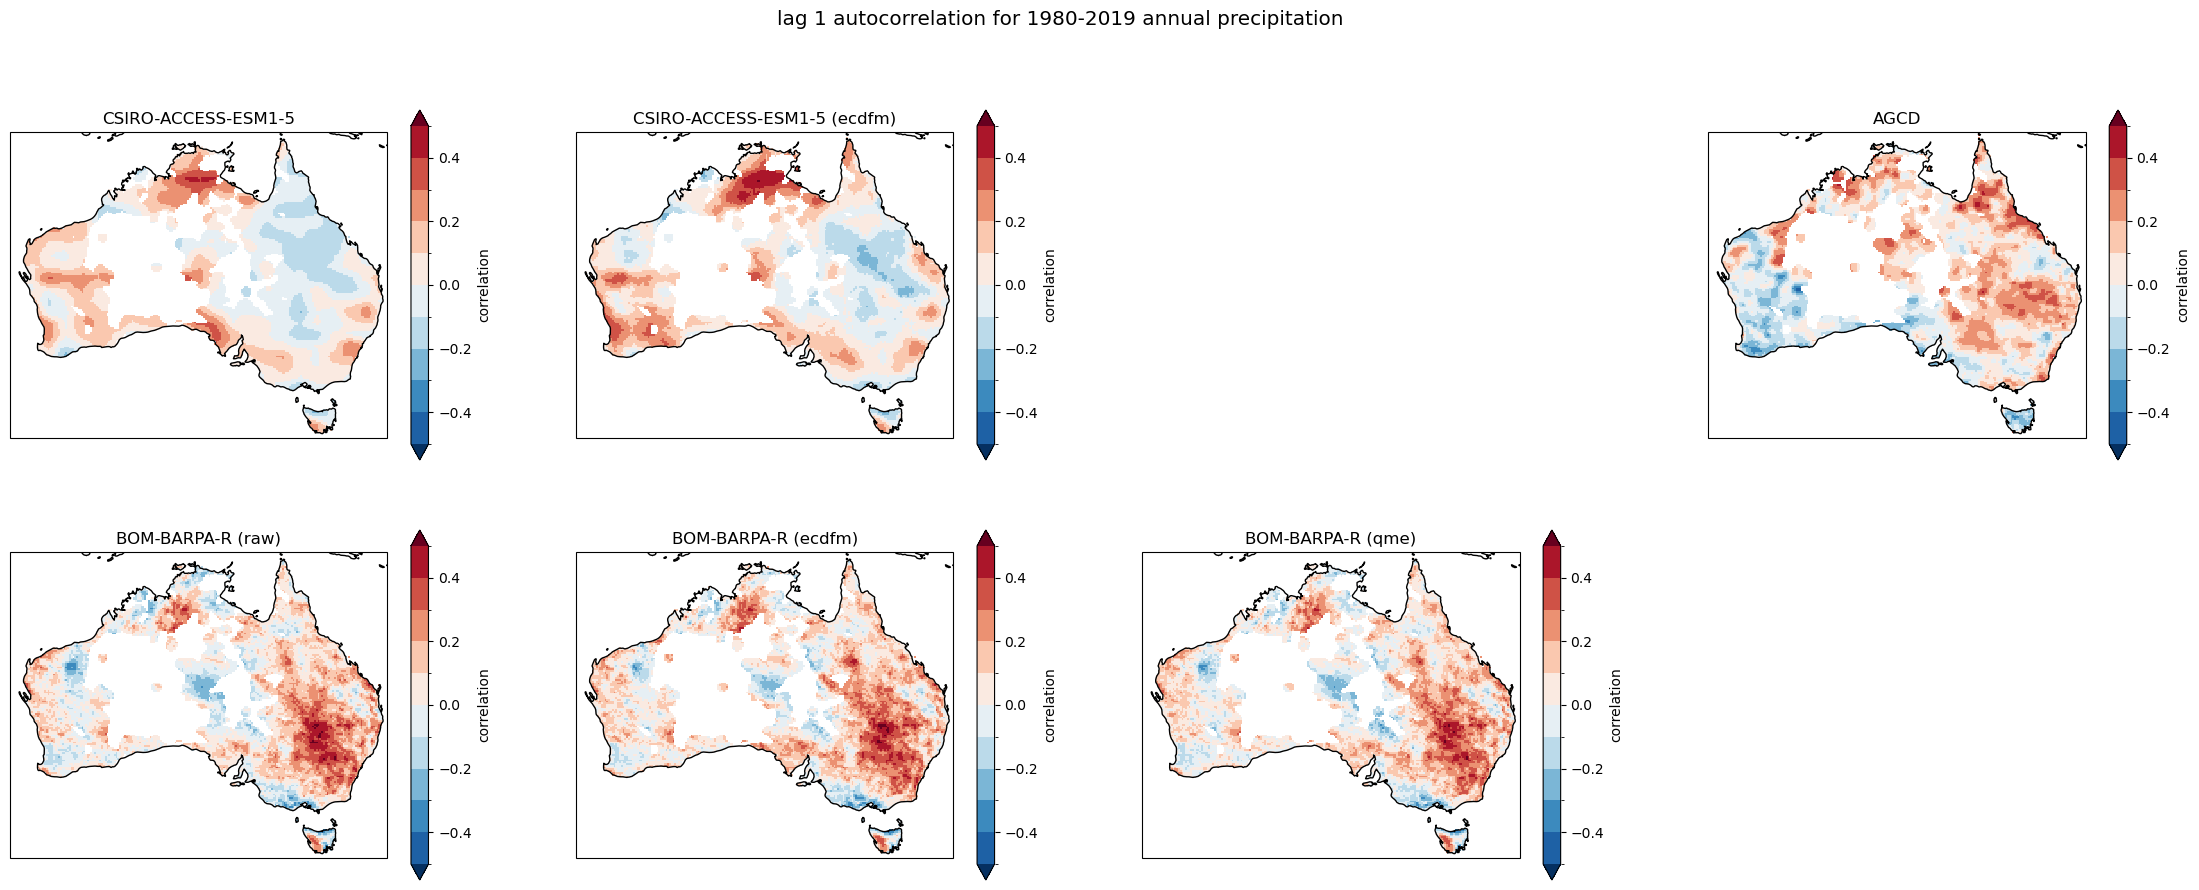

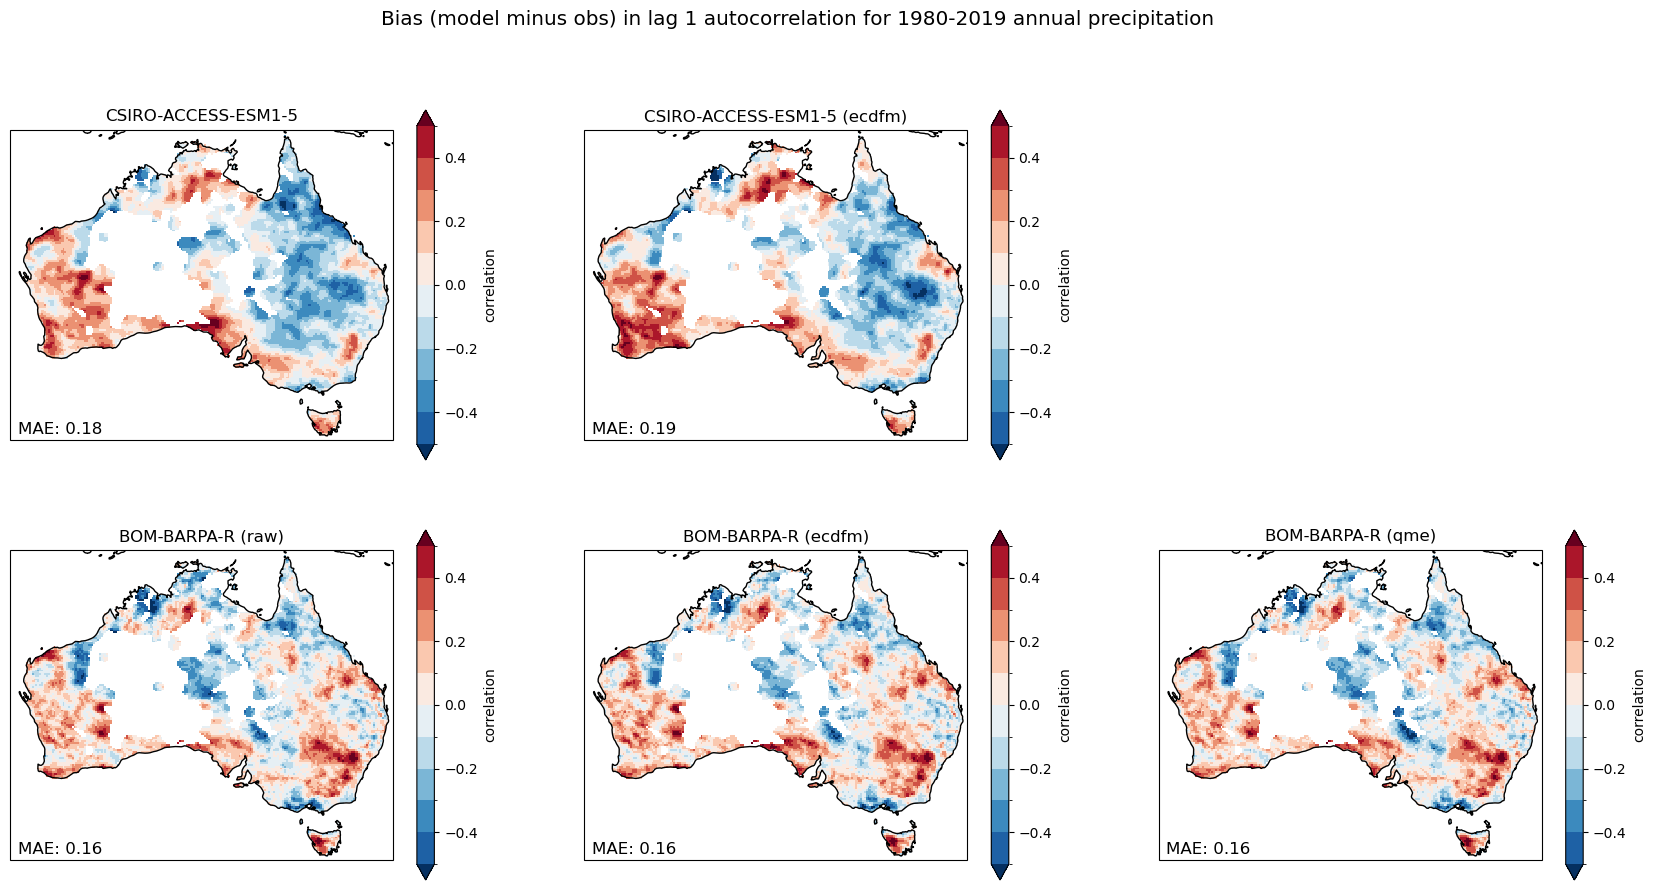

In [31]:
rcm = 'BOM-BARPA-R'
plot_rcm(variable, tscale, da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date, value_plot=True)

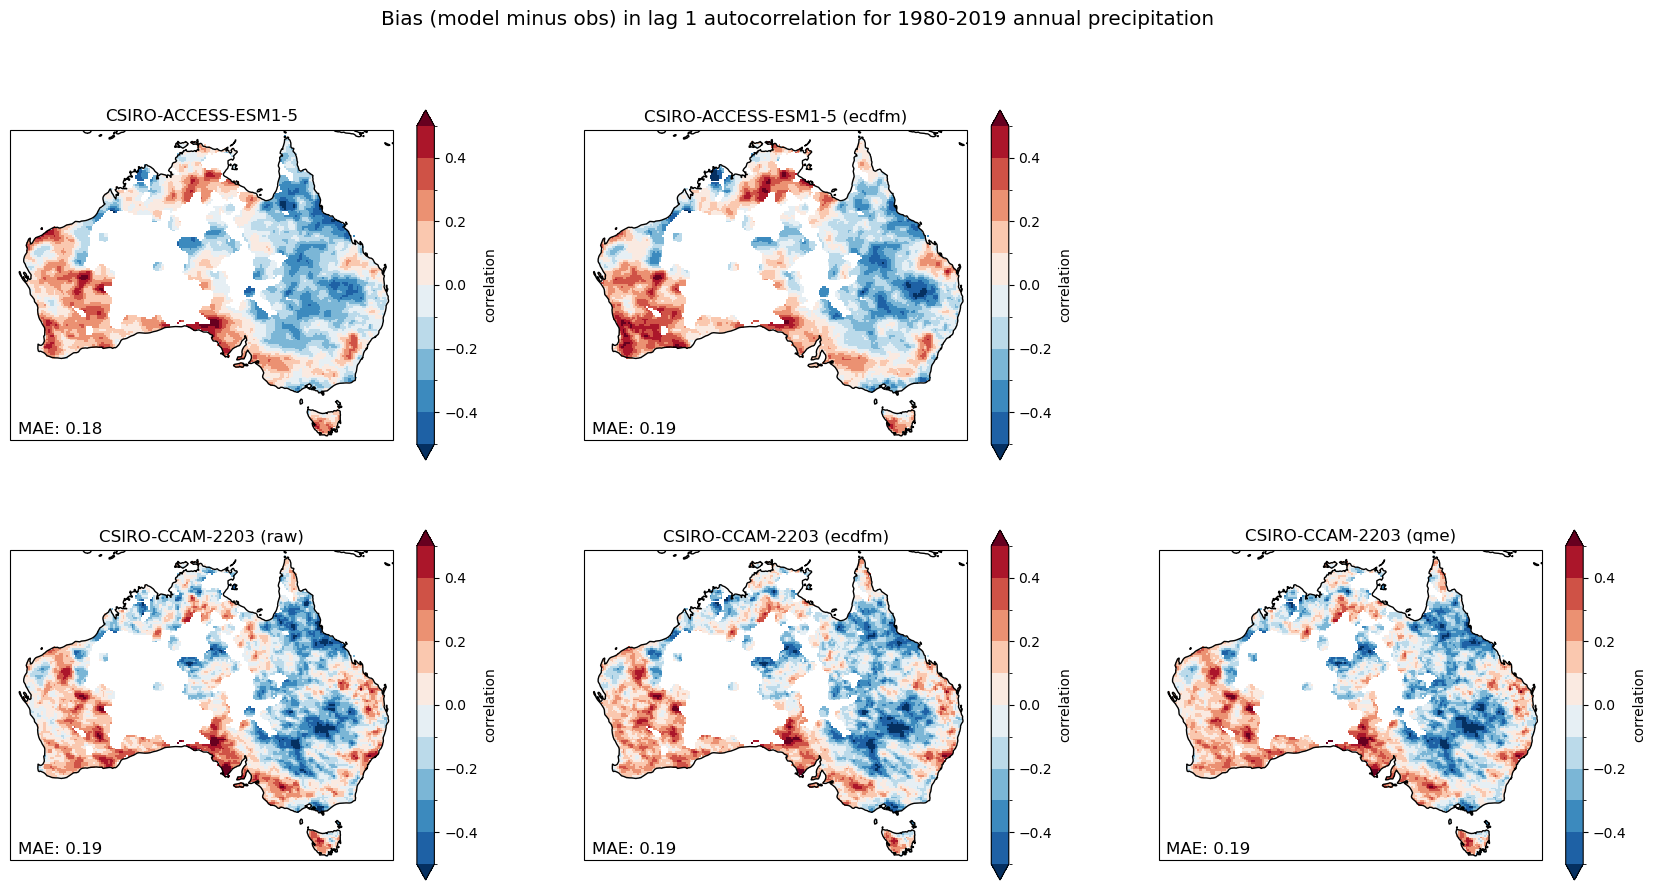

In [33]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(variable, tscale, da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date)

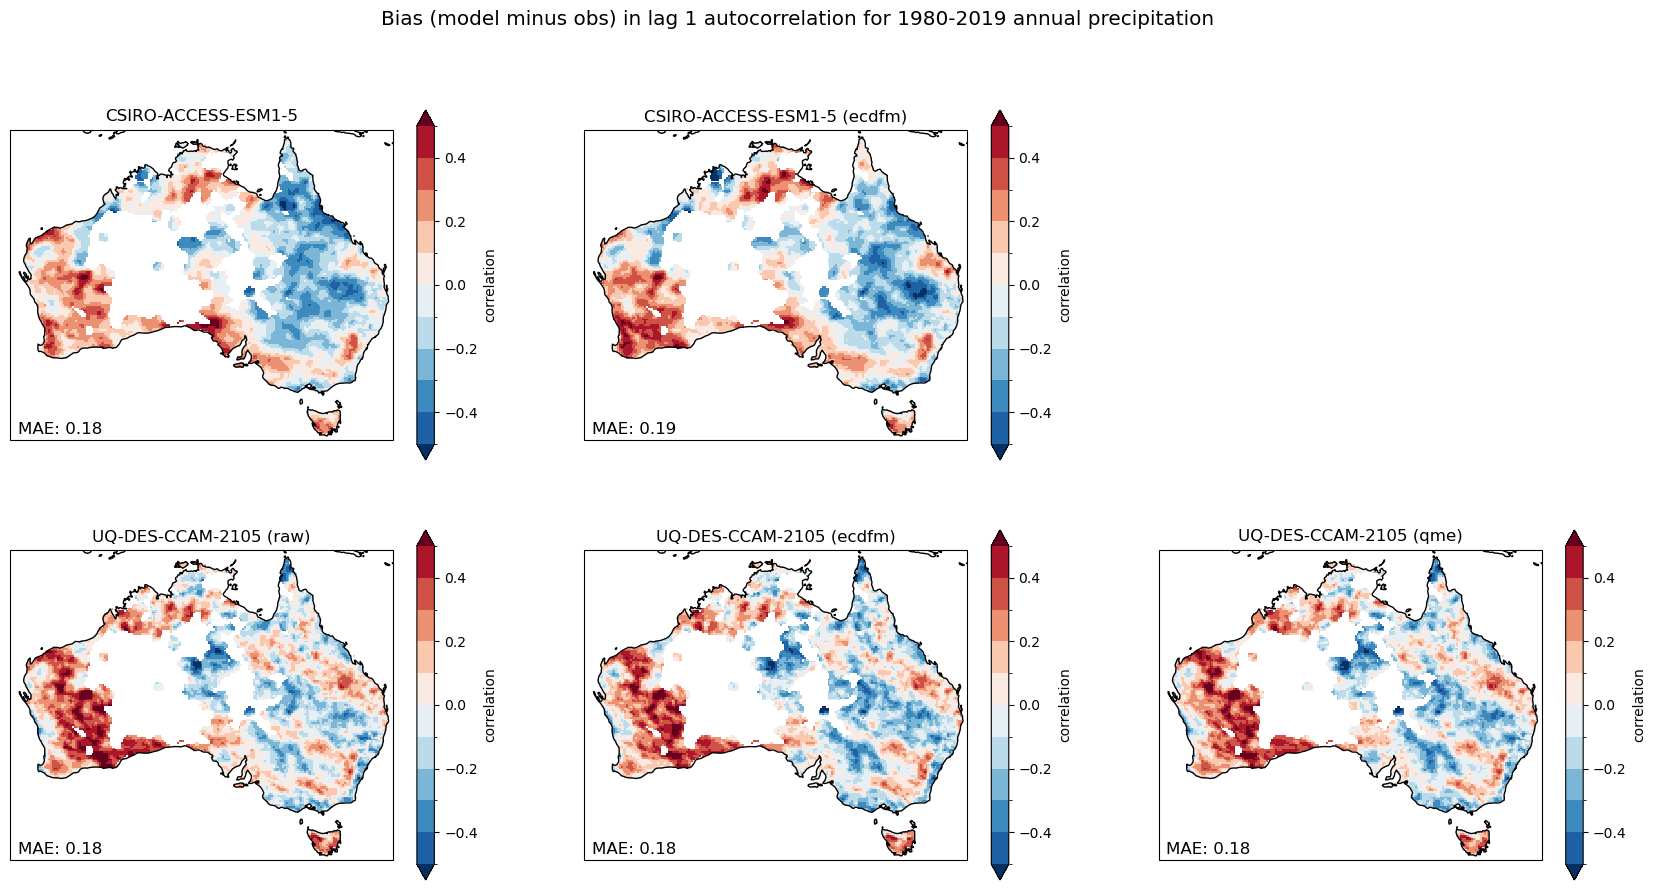

In [34]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(variable, tscale, da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date)

## task-xvalidation

#### ERA5

Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [14]:
#gcm = 'ECMWF-ERA5'
#task = 'xvalidation'
#start_date, end_date = get_assessment_time_bounds(gcm, task)
#da_obs = get_obs_data(variable, tscale, start_date, end_date)
#da_gcm = get_gcm_data(variable, tscale, gcm, start_date, end_date)
#gcm_bc_dict = get_bias_corrected_gcm_data(variable, tscale, gcm, task, start_date, end_date)

#training_start, training_end = get_training_time_bounds(gcm)
#da_training_obs = get_obs_data(variable, tscale, training_start, training_end)

In [15]:
#rcm = 'BOM-BARPA-R'
#plot_rcm(variable, tscale, da_obs, da_gcm, gcm_bc_dict gcm, rcm, task, start_date, end_date, da_training_obs)

In [16]:
#rcm = 'CSIRO-CCAM-2203'
#plot_rcm(variable, tscale, da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date, da_training_obs)

In [17]:
#rcm = 'UQ-DES-CCAM-2105'
#plot_rcm(variable, tscale, da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date, da_training_obs)

#### ACCESS-ESM1-5

Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

In [35]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'xvalidation'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, tscale, start_date, end_date)
da_gcm = get_gcm_data(variable, tscale, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, tscale, gcm, task, start_date, end_date)

training_start, training_end = get_training_time_bounds(gcm)
da_training_obs = get_obs_data(variable, tscale, training_start, training_end)

lag1autocorr-values_task-xvalidation_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R.png


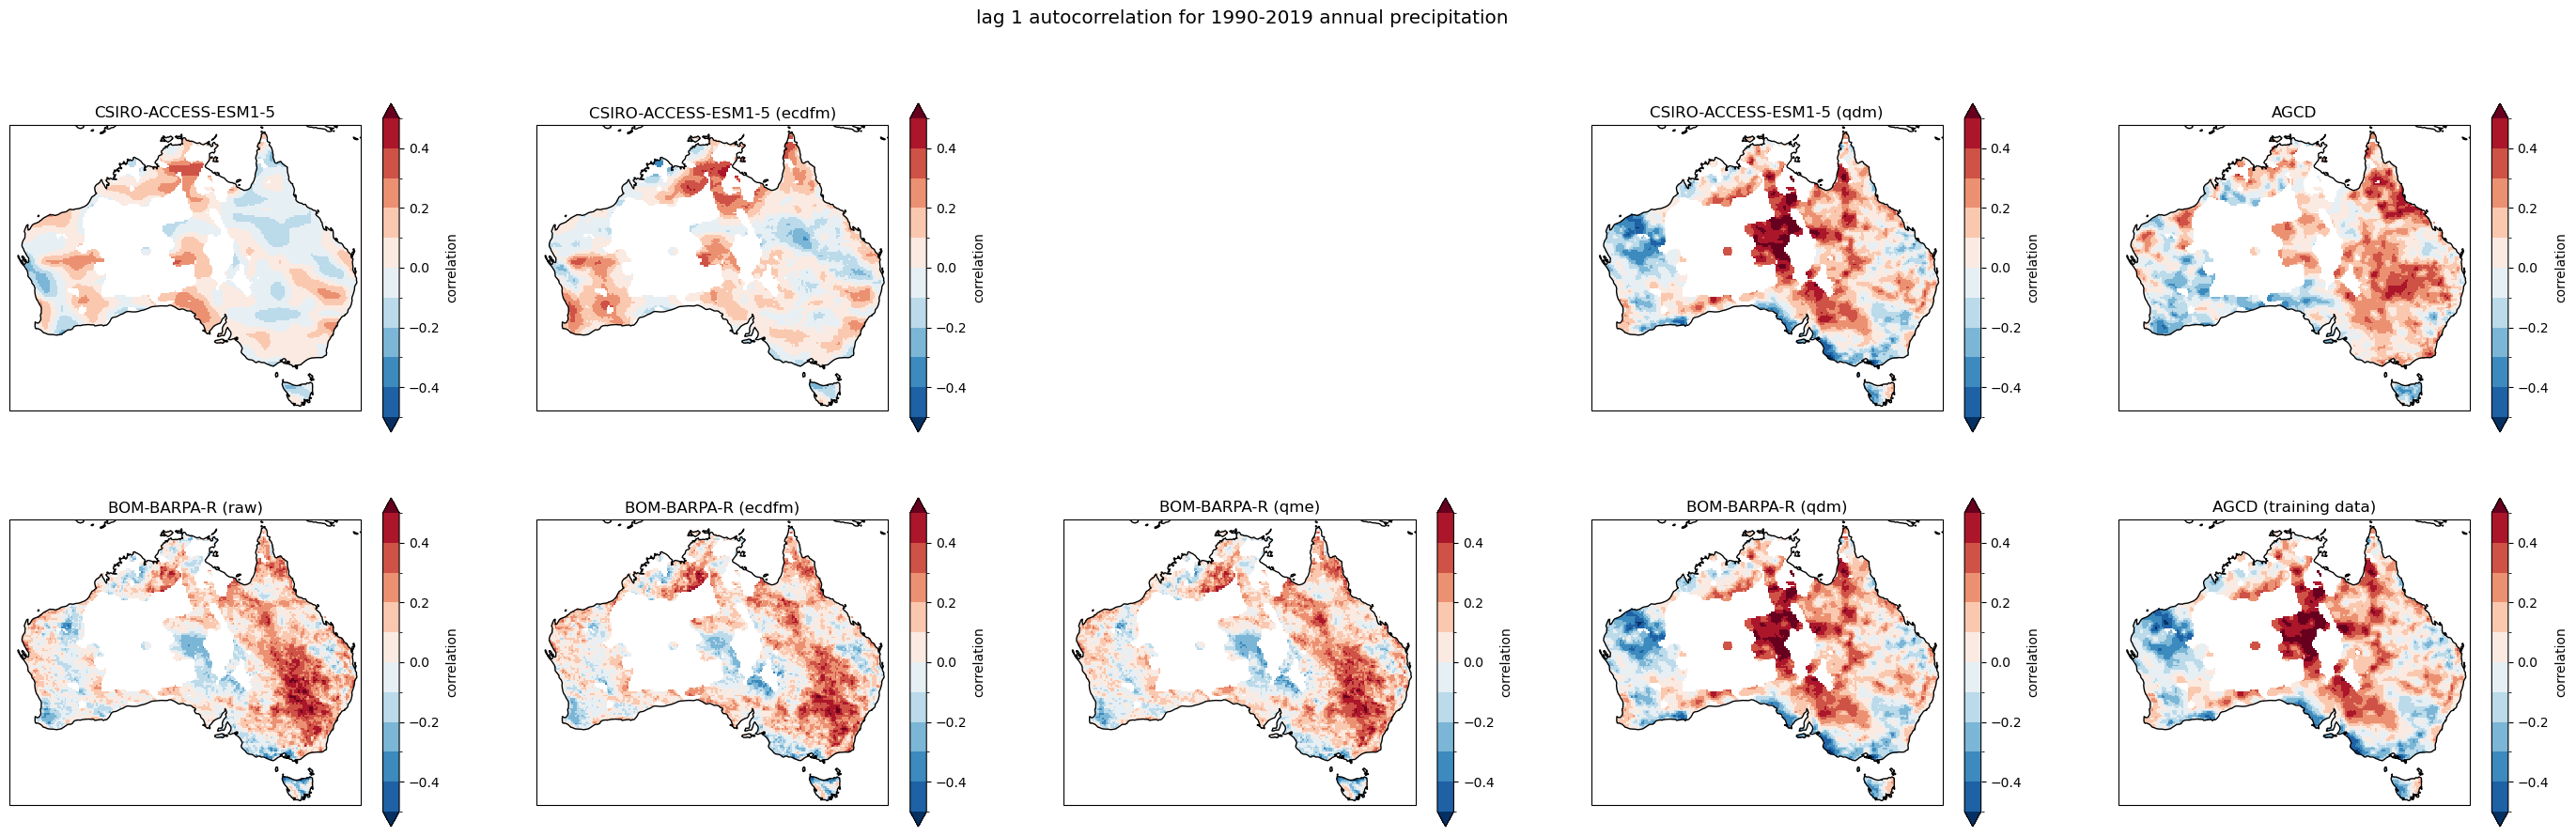

lag1autocorr-bias_task-xvalidation_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R.png


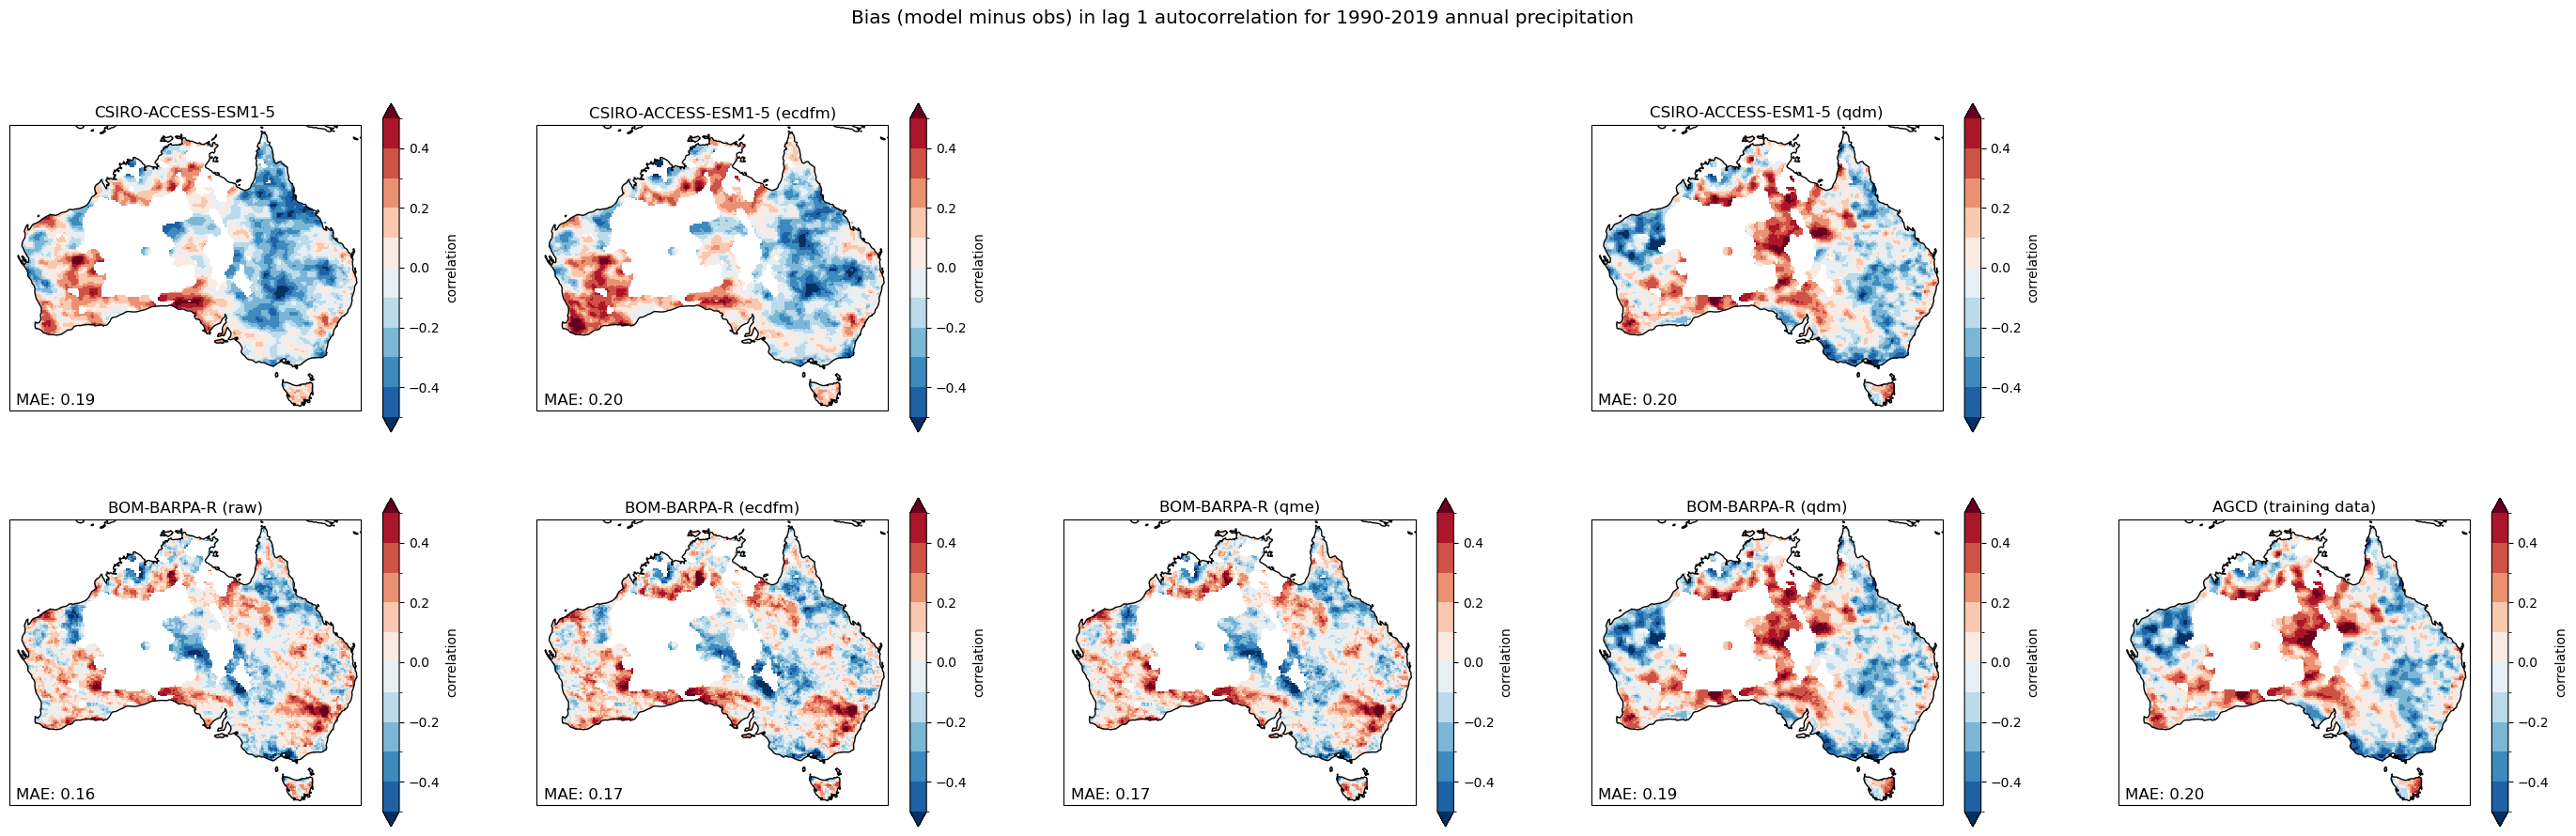

In [36]:
rcm = 'BOM-BARPA-R'
plot_rcm(
    variable,
    tscale,
    da_obs,
    da_gcm,
    gcm_bc_dict,
    gcm,
    rcm,
    task,
    start_date,
    end_date,
    da_training_obs,
    bias_outfile=True,
    value_outfile=True,
    value_plot=True
)

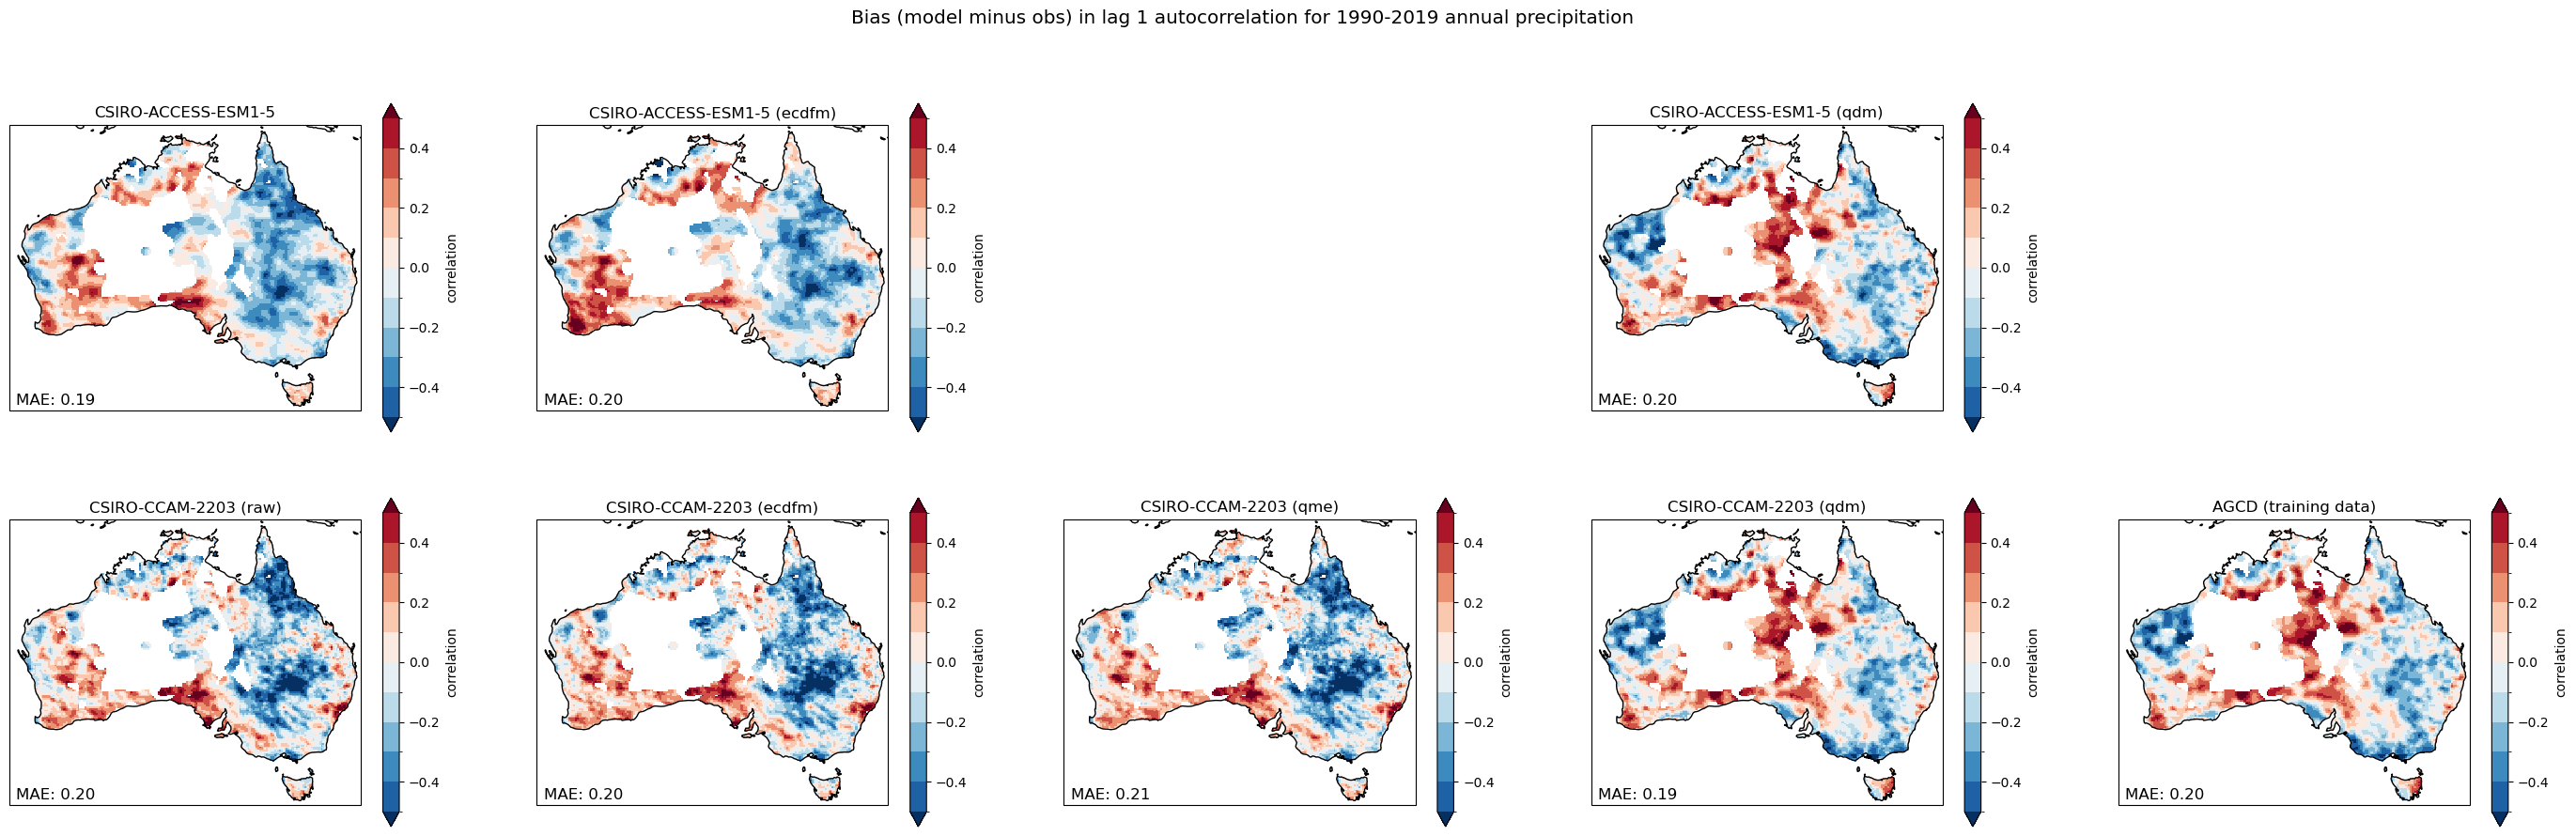

In [37]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(variable, tscale, da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date, da_training_obs)

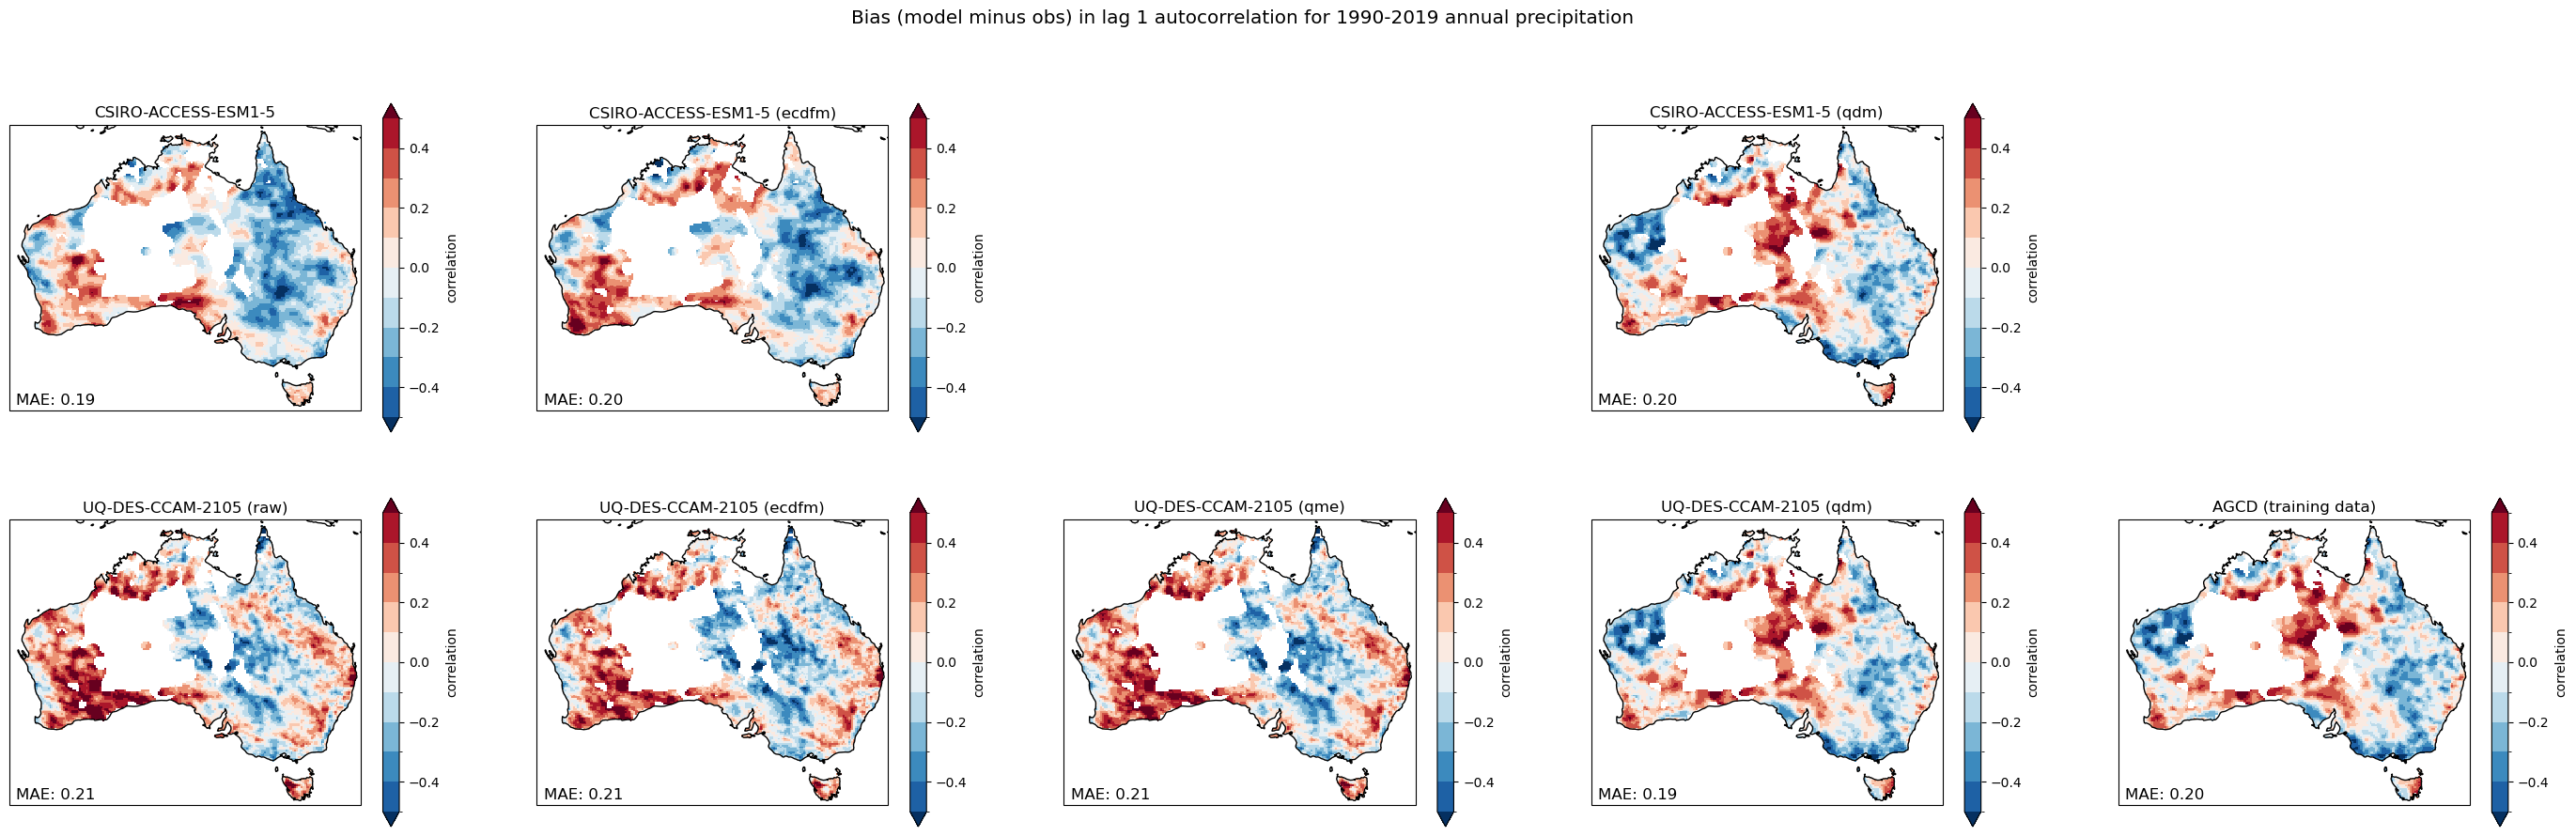

In [38]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(variable, tscale, da_obs, da_gcm, gcm_bc_dict, gcm, rcm, task, start_date, end_date, da_training_obs)